Scale Analysis Example
====
Using scales from Rabia Sevil, which is why this file is named like it is

We'll read the LIF files, try to segment them out and then run EFA to summarise their shape variation.
So far I've only done this on the ALP scales, since they looked like they'd be easiest to segment.

Research Question
----
#### What morphological differences are there between hom/wt and onto/regen scales?

NB:
 - hom = mutant (their bones form far quicker than normal, or something)
 - wt = wildtype, as they appear in the wild
 - onto = fully formed scales
 - regen = scales that are still growing

we'd expect the hom scales to be weird shapes, the regen scales to be smaller...

Read in the scales
----
I've segmented the scales out following the process in [the segmentation notebook](segmentation.ipynb).

This involved:
 - making an initial rough segmentation by thresholding
 - Running SAM (a transformer-based model from Meta) on the scales, using the rough segmentation as a prior
 - manually tidying them up where necessary

In [1]:
"""
Read in the images + various segmentations
"""

import pathlib
import tifffile

segmentation_dir = pathlib.Path("segmentation")
assert segmentation_dir.is_dir()

dirs = [
    segmentation_dir / "images",
    segmentation_dir / "mask_priors",
    segmentation_dir / "sam_masks",
    segmentation_dir / "cleaned_masks",
]

names, images, rough_segmentations, sam_segmentations, clean_segmentations = (
    [],
    [],
    [],
    [],
    [],
)
for img_path, rough_path, sam_path, clean_path in zip(
    *(sorted(list(d.glob("*.tif"))) for d in dirs)
):
    name = img_path.name
    assert name == rough_path.name == sam_path.name == clean_path.name

    images.append(tifffile.imread(img_path))
    rough_segmentations.append(tifffile.imread(rough_path))
    sam_segmentations.append(tifffile.imread(sam_path))
    clean_segmentations.append(tifffile.imread(clean_path))
    names.append(name)

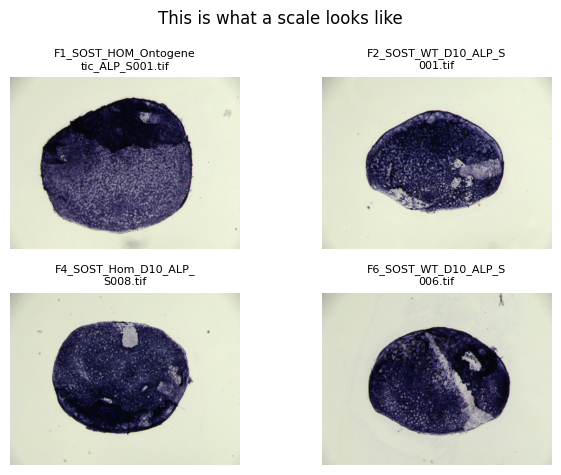

In [2]:
import textwrap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2)
# Pick some different looking scales
for axis, i in zip(axes.flat, (0, 90, 180, 270)):
    axis.imshow(images[i])
    axis.set_title("\n".join(textwrap.wrap(names[i], width=20)), fontsize=8)
    axis.set_axis_off()
fig.suptitle("This is what a scale looks like")
fig.tight_layout()

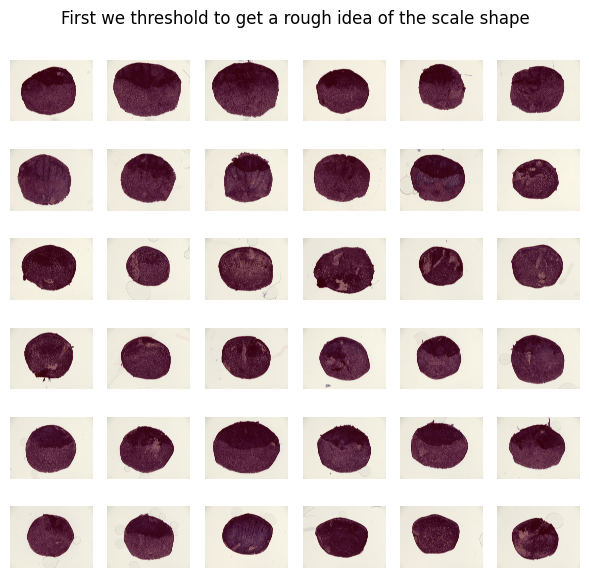

In [3]:
"""
Show a couple of the segmentations at different stages on top of the actual images
"""


def plot_masks(masks, title):
    fig, axes = plt.subplots(6, 6, figsize=(6, 6))
    for axis, img, mask in zip(axes.flat, images, masks):
        axis.imshow(img, cmap="grey")
        axis.imshow(mask, alpha=0.5, cmap="Reds")
        axis.set_axis_off()

    fig.suptitle(title)
    fig.tight_layout()


plot_masks(
    rough_segmentations, "First we threshold to get a rough idea of the scale shape"
)

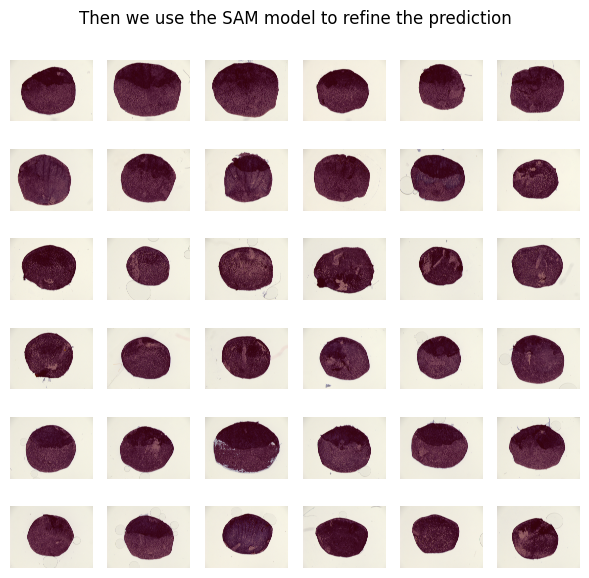

In [4]:
plot_masks(sam_segmentations, "Then we use the SAM model to refine the prediction")

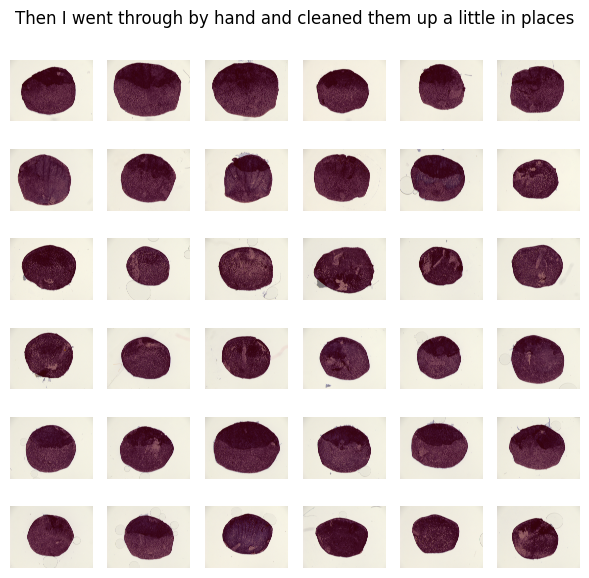

In [5]:
plot_masks(clean_segmentations, "Then I went through by hand and cleaned them up a little in places")

Elliptical Fourier Analysis
----
We'll summarise their shapes using Elliptical Fourier Analysis (EFA)
<a name="cite_ref-1"></a><sup>[1]</sup>
<a name="cite_ref-2"></a><sup>[2]</sup>,
which basically decomposes the boundary into sums of ellipses.
The coefficients (strength and direction of each size of ellipse) tell us about the shape of the object.
There's a demonstration of how this works [here](https://reinvantveer.github.io/2019/07/12/elliptical_fourier_analysis.html).

Our edge is constructed as:

\begin{aligned}
x(t) &= a_0 + \sum_{n=1}^{N} \big[a_n \cos(n t) + b_n \sin(n t)\big],\\
y(t) &= c_0 + \sum_{n=1}^{N} \big[c_n \cos(n t) + d_n \sin(n t)\big],
\qquad t \in [0, 2\pi].
\end{aligned}

with:

\begin{aligned}
a_0 = \frac{1}{2\pi}\int_{0}^{2\pi} x(t)\,dt,\qquad
c_0 = \frac{1}{2\pi}\int_{0}^{2\pi} y(t)\,dt.
\end{aligned}

\begin{aligned}
a_n &= \frac{1}{\pi}\int_{0}^{2\pi} x(t)\cos(n t)\,dt, &
b_n &= \frac{1}{\pi}\int_{0}^{2\pi} x(t)\sin(n t)\,dt,\\
c_n &= \frac{1}{\pi}\int_{0}^{2\pi} y(t)\cos(n t)\,dt, &
d_n &= \frac{1}{\pi}\int_{0}^{2\pi} y(t)\sin(n t)\,dt.
\end{aligned}

possibly up to some factors of $2\pi$

In [6]:
"""
First tidy the masks up a little, because I broke some of them when cleaning them
"""
import numpy as np
from scipy.ndimage import binary_fill_holes
from scale_morphology.scales.segmentation import largest_connected_component

masks = [
    255 * largest_connected_component(binary_fill_holes(m)).astype(np.uint8)
    for m in clean_segmentations
]

In [7]:
"""
Perform EFA on the scales and plot the reconstruction
"""
import numpy as np
from tqdm.notebook import tqdm
from scale_morphology.scales import efa, errors, segmentation


n_edge_points = 100
order = 30

coeffs = []
for scale in tqdm(masks):
    try:
        coeffs.append(efa.coefficients(scale, n_edge_points, order))
    except errors.BadImgError as e:
        coeffs.append(np.ones((order, 4)) * np.nan)
        print(f"\nError processing scale: {e}. NaN coeffs")
coeffs = np.stack(coeffs)

  0%|          | 0/290 [00:00<?, ?it/s]

Text(0.5, 0.98, 'I broke the plotting but this is how it works')

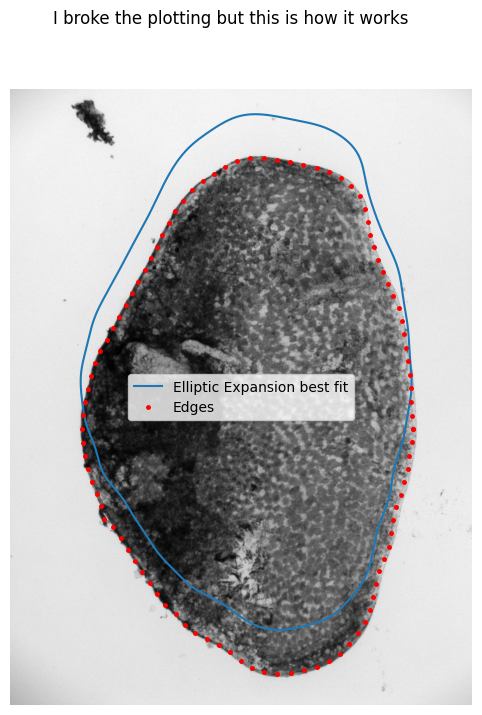

In [8]:
i = 100
fig, axis = plt.subplots(figsize=(8,8))
axis.imshow(images[i].sum(axis=2).T, origin="lower", cmap="grey")
axis.set_aspect("equal")

locus = [np.average(x) for x in np.where(scale > 0)]
x, y = efa.coeffs2points(coeffs[i], locus[::-1])
axis.plot(y, images[i].shape[1] - x, label="Elliptic Expansion best fit")

x, y = efa.points_around_edge(masks[i], 100)
axis.plot(x, y, "r.", markersize=5, label="Edges")

axis.set_axis_off()
axis.legend()

fig.suptitle("I broke the plotting but this is how it works")

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

images = np.array(masks)
flat_coeffs = coeffs.reshape((coeffs.shape[0], -1))

pca = PCA(n_components=2)
transformed_coeffs = np.ascontiguousarray(pca.fit_transform(flat_coeffs))

In [10]:
from scale_morphology.scales import dashboard

embeddable_imgs = [
    dashboard.embeddable_image(i.astype(np.uint8)) for i in tqdm(clean_segmentations)
]


colours = []


def _colour(name):
    name = name.lower()
    if "hom" in name:
        if "ontogenetic" in name:
            return "Hom Onto"
        return "Hom Regen"
    if "ontogenetic" in name:
        return "WT Onto"
    return "WT Regen"


for name in names:
    colours.append(str(_colour(name)))

dashboard_df = pd.DataFrame(transformed_coeffs, columns=["x", "y"])
dashboard_df["image"] = embeddable_imgs
dashboard_df["colour"] = colours
dashboard_df["name"] = names

dashboard_df

  0%|          | 0/290 [00:00<?, ?it/s]

,x,y,image,colour,name
0,27.101153,-15.760721,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Hom Onto,F1_SOST_HOM_Ontogenetic_ALP_S001.tif
1,205.508925,-14.699410,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Hom Onto,F1_SOST_HOM_Ontogenetic_ALP_S002.tif
2,193.274697,-26.642139,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Hom Onto,F1_SOST_HOM_Ontogenetic_ALP_S003.tif
3,-25.300316,-5.181857,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Hom Onto,F1_SOST_HOM_Ontogenetic_ALP_S004.tif
4,-55.418842,-32.663898,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Hom Onto,F1_SOST_HOM_Ontogenetic_ALP_S005.tif
...,...,...,...,...,...
285,-165.591287,36.037720,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",WT Onto,F6_SOST_WT_Ontogenetic_ALP_S005.tif
286,-191.916338,32.740810,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",WT Onto,F6_SOST_WT_Ontogenetic_ALP_S006.tif
287,59.098736,14.023081,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",WT Onto,F6_SOST_WT_Ontogenetic_ALP_S007.tif
288,-113.927946,-12.521368,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",WT Onto,F6_SOST_WT_Ontogenetic_ALP_S008.tif


In [11]:
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.resources import INLINE
from scipy.spatial import ConvexHull

factors = np.unique(dashboard_df["colour"])
mapper = CategoricalColorMapper(factors=factors, palette=f"Category10_4")

datasource = ColumnDataSource(dashboard_df)
fig = figure(
    title="Test", width=800, height=800, tools="pan, wheel_zoom, box_zoom, reset"
)

fig.add_tools(
    (
        HoverTool(
            tooltips="""
<div>
    <div>
        <img src="@image" style="float: left; margin: 5px 5px 5px 5px;">
    </div>
    <div>
        <span style="font-size: 17px; font-weight: bold;">@name</span>
    </div>
</div>
"""
        )
    )
)


fig.scatter(
    x="x",
    y="y",
    source=datasource,
    size=4,
    color={"field": "colour", "transform": mapper},
    legend_field="colour",
)

for i, colour_value in enumerate(np.unique(dashboard_df["colour"])):
    group_points = dashboard_df[dashboard_df["colour"] == colour_value][
        ["x", "y"]
    ].values

    if len(group_points) >= 3:
        hull = ConvexHull(group_points)

        vertices = group_points[hull.vertices]

        # Close the polygon by adding the first point at the end
        vertices = np.vstack([vertices, vertices[0]])

        hull_color = mapper.palette[i % len(mapper.palette)]
        fig.patch(
            x=vertices[:, 0],
            y=vertices[:, 1],
            alpha=0.2,
            line_color=hull_color,
            line_width=2,
            fill_color=hull_color,
        )

filename = "test_dashboard.html"
save(
    fig,
    filename=filename,
    title=pathlib.Path(filename.replace(".html", "")).name,
    resources=INLINE,
)

'/home/mh19137/scale_morphology/src/notebooks/test_dashboard.html'

In [12]:
from scale_morphology.scripts.plotting import interpret_dimensions

interpret_dimensions._plot_pca_importance(
    flat_coeffs, np.zeros(flat_coeffs.shape[0], dtype=bool)
)

In [13]:
sizes = [np.sum(m) / 255 for m in tqdm(np.array(masks))]

  0%|          | 0/290 [00:00<?, ?it/s]

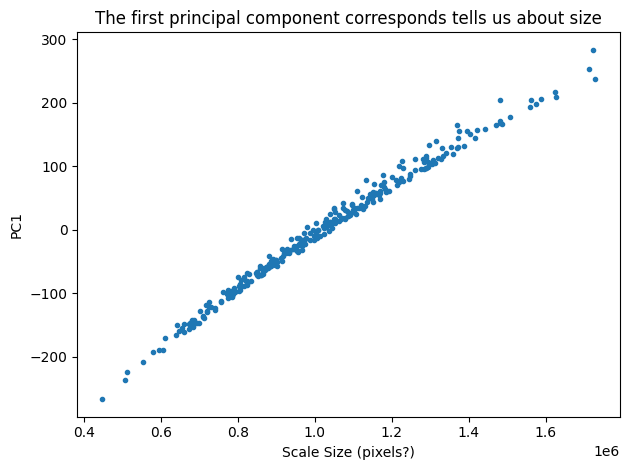

In [14]:
plt.plot(sizes, transformed_coeffs[:, 0], ".")
plt.xlabel("Scale Size (pixels?)")
plt.ylabel("PC1")
plt.title("The first principal component corresponds tells us about size")
plt.tight_layout()

plot_dir = pathlib.Path("rabia")
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir /"sizes.png")

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_coeffs = lda.fit_transform(flat_coeffs, colours)

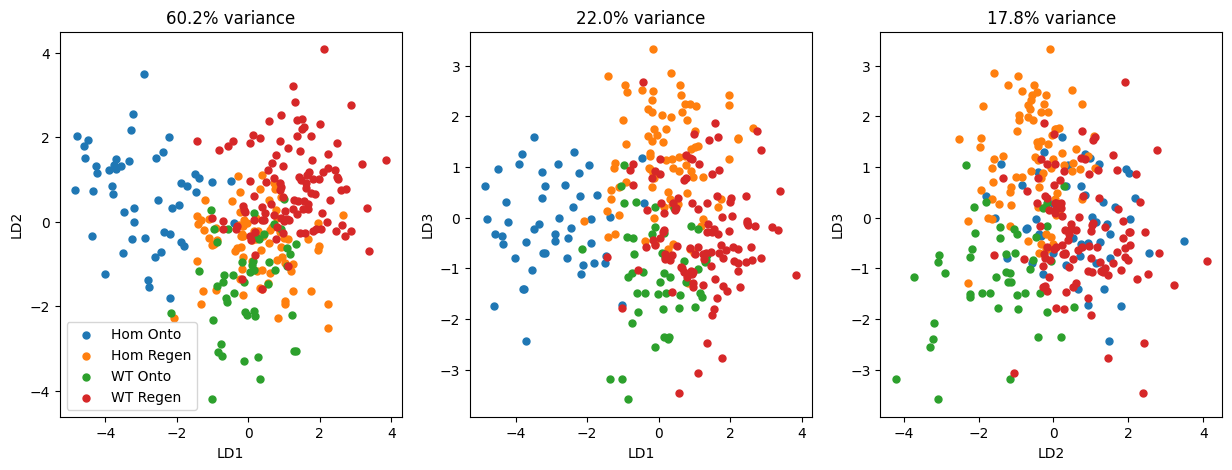

In [55]:
from itertools import combinations

ld_names = [f"LD{i}" for i in range(1, lda_coeffs.shape[1] + 1)]
explained_variance = lda.explained_variance_ratio_

ld_df = pd.DataFrame(lda_coeffs, columns=ld_names)
ld_df["colour"] = colours
ld_df["name"] = [x.strip(".tif") for x in names]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for axis, (i, j), var in zip(
    axes, combinations(range(1, 4), 2), explained_variance
):  # 3 choose 2
    for cls in np.unique(colours):
        d = ld_df[ld_df["colour"] == cls]
        x, y = f"LD{i}", f"LD{j}"
        axis.scatter(d[x], d[y], s=25, label=cls)

        axis.set_xlabel(x)
        axis.set_ylabel(y)

        axis.set_title(f"{100*var:.1f}% variance")
axes[0].legend()

But what do these axes mean?
----
Ideally we want to understand intuitively what it means for LD1 to be the best axis for discrimination - e.g. does this mean the the Hom Onto scales are bigger/flatter/lumpier/... etc.?

We can do this in two ways:
 1. Analytically: by looking at the components of the LDA axes, we might be able to work out what they mean (e.g. if they correspond to the $a_0$ and $d_0$ coefficients, this means they're size or circularness or something). This is hard
 2. Empirically: we can take a grid of points along our LDA axes, project them back into the original coefficient space and then draw the shapes that these correspond to. This means we should be able to see by eye what each axis corresponds to.

I will do this soon

[^1](#cite_ref-1):  F. P. Kuhl and C. R. Giardina, ‘Elliptic Fourier features of a closed contour’, Computer Graphics and Image Processing, vol. 18, no. 3, pp. 236–258, Mar. 1982, doi: 10.1016/0146-664x(82)90034-x. 

[^2](#cite_ref-2): N. MacLeod, 'PalaeoMath 101 part 25: the centre cannot hold II: Elliptic fourier
analysis.' Palaeontol. Assoc. Newslett. 79, 29–43, 2012 http://go.palass.org/65a.